# Mask functions

In [53]:
from skimage import measure
from scipy import ndimage
import cv2
import numpy as np


def recolor_resize(img, pix=256):
    try:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    except:
        print('', end = '')
    img = cv2.resize(img, (pix, pix))
    img = np.expand_dims(img, axis=-1)
    return img


def recolor(img):
    try:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    except:
        print('', end = '')
    return img


def normalize(img):
    return (img - np.mean(img))/ np.std(img)


def quitar_trozos(mask):
    mask = measure.label(mask)
    ntotal = {k: (k==mask).sum() for k in np.unique(mask) if k >0}
    k = list(ntotal.keys())[np.argmax(list(ntotal.values()))]
    mask = k==mask
    mask = ndimage.binary_fill_holes(mask, structure=np.ones((5,5)))
    return mask


def des_normalize(img):
    return cv2.normalize(img, None, alpha = 0, beta = 255,
                         norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_16UC1)


def apply_mask(img, model):
    pix1 = img.shape[0]
    pix2 = img.shape[1]
    # Paso la imagen a escala de grises
    img = recolor(img)
    # Creo una nueva imagen con las dimensiones de entrada al modelo
    img_2 = normalize(recolor_resize(img, 256))[np.newaxis,...]
    # Genero la mascara
    mask = model.predict(img_2)[0,...]
    # Escalo la mascara generada al tamaño de la imagen de entrada
    mask = cv2.resize(mask, (pix2, pix1))
    # Limpio la mascara
    mask = quitar_trozos(mask > 0.5)
    return img*mask

# Losses

In [49]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [51]:
from tensorflow.keras import backend as K
from tensorflow import keras
import os

def list_files(path):
    return [f for f in os.listdir(path) 
                if os.path.isfile(os.path.join(path, f))]

def dice_coef(y_true, y_pred, smooth=100):        
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice


def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)


loss_model = keras.models.load_model('/home/mr1142/Documents/Data/models/mascaras/mask_1.h5', 
                                    custom_objects={"dice_coef_loss": dice_coef_loss, "dice_coef": dice_coef})
sub_mask = keras.Model(inputs=loss_model.input, outputs=loss_model.layers[18].output)
sub_mask.trainable = False


def loss_mask(y_true, y_pred):
    y_pred = sub_mask(y_pred)
    y_true = sub_mask(y_true)
    return 0.6*abs(y_true - y_pred)


def MyLoss(y_true, y_pred):
    # Loss 1
    loss1 = dice_coef_loss(y_true, y_pred)
    # Loss 2
    loss2 = loss_mask(y_true, y_pred)
    loss = loss1 + loss2
    return loss

# Prepare img

In [52]:
import os

import cv2
import tensorflow.keras as keras



mask_model = os.path.join('/home/mr1142/Documents/Data/models/mascaras', 'unet_final_renacimiento_validation_6.h5')
mask_model = keras.models.load_model(mask_model, 
                                    custom_objects={"MyLoss": MyLoss, 
                                                    "loss_mask": loss_mask, 
                                                    "dice_coef_loss": dice_coef_loss,
                                                    "dice_coef": dice_coef})


def clahe(img):
    clahe = cv2.createCLAHE(clipLimit = 20)
    final_img = clahe.apply(img)
    return final_img


def get_prepared_img(img, pix):
    segmented = des_normalize(apply_mask(img, mask_model))
    segmented = recolor_resize(segmented, pix)
    segmented = normalize(segmented)
    return segmented

# Data Generator

In [40]:
from tensorflow.keras.utils import Sequence
import numpy as np
import math

class DataGenerator(Sequence):

    def __init__(self, x_set, y_set, batch_size, pix, index):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.pix = pix
        index.sort()
        self.index = index

    def __len__(self):
        # numero de batches
        return math.ceil(len(self.index) / self.batch_size)

    def __getitem__(self, idx):
        # idx: numero de batch
        # batch 0: idx = 0 -> [0*batch_size:1*batch_size]
        # batch 1: idx = 1 -> [1*batch_size:2*batch_size]
        # Lo que hago es recorrer el indice
        index = self.index[idx * self.batch_size:(idx + 1) * self.batch_size]
        temp_x = self.x[index]
        batch_y = self.y[index]
        batch_x = np.zeros((temp_x.shape[0], self.pix, self.pix, 1))
        for i in range(temp_x.shape[0]):
            # Compruebo el numero de valores entre 0.1 y 0.9 (si es menos del 50% creo una imagen de ruido)
            try:
                batch_x[i] = get_prepared_img(temp_x[i], self.pix)
            except:
                img = np.random.randint(0,255,self.pix*self.pix).reshape((self.pix, self.pix, 1))
                batch_x[i] = normalize(img)
        return np.array(batch_x), np.array(batch_y)

# Ver los datos

In [1]:
import h5py as f
df = f.File("/home/rs117/covid-19/data/cxr_consensus_dataset_nocompr.h5", "r")

for key in df.keys():
    globals()[key] = df[key]

pix = 512
batch = 8

In [57]:
X_train.shape

(59439, 1024, 1024, 3)

In [58]:
img = X_train[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


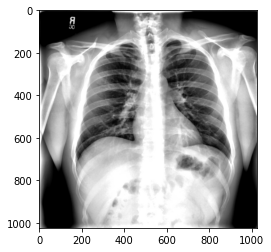

In [59]:
plt.imshow(img/60000)

In [21]:
import numpy as np

In [118]:
r = np.random.randint(0,len(X_train),200)

In [119]:
r.sort()

In [120]:
r[:10]

array([ 137, 1003, 1148, 1237, 1836, 2097, 2868, 3007, 4429, 4486])

In [121]:
muestra_X = X_train[r,...]
muestra_y = y_train[r,...]

In [122]:
normal = muestra_X[muestra_y[:,0] == 1,...]
leve = muestra_X[muestra_y[:,1] == 1,...]
grave = muestra_X[muestra_y[:,2] == 1,...]

In [123]:
import matplotlib.pyplot as plt

In [141]:
lr = 1e-5
str(lr)[2:]

'-05'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


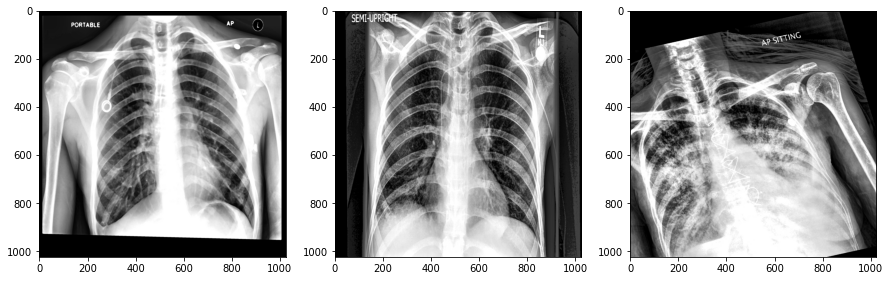

In [149]:
r1 = np.random.randint(0, len(normal))
r2 = np.random.randint(0, len(leve))
r3 = np.random.randint(0, len(grave))

fig, ax = plt.subplots(1,3, figsize=(15, 15))
ax[0].imshow(normal[r1,...]/60000)
ax[1].imshow(leve[r2,...]/60000)
ax[2].imshow(grave[r3,...]/60000)

In [61]:
segmented = des_normalize(apply_mask(img, mask_model))

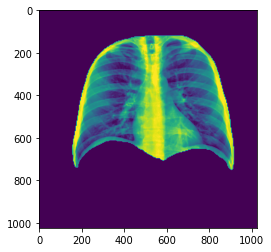

In [62]:
plt.imshow(segmented)

In [63]:
segmented = recolor_resize(segmented, pix)
segmented = normalize(segmented)

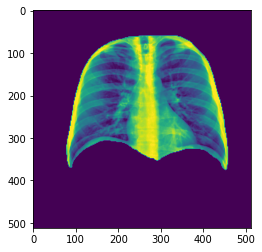

In [64]:
plt.imshow(segmented)

In [65]:
segmented.shape

(512, 512, 1)

In [ ]:
ids = np.r_[0:len(df['X_train'])]
np.random.shuffle(ids)
trainprop = 0.8
idtrain = ids[:int(len(df['X_train'])*trainprop)]
idtest = ids[int(len(df['X_train'])*trainprop):]

traingen = DataGenerator(X_train, y_train, batch, pix, idtrain[0:500])
testgen = DataGenerator(X_train, y_train, batch, pix, idtest[0:200])

In [55]:
import cv2
import os
import matplotlib.pyplot as plt


def hist(img, name):
    plt.hist(img.flatten())
    plt.savefig(os.path.join(path, name + '.png'))

def simg(img, name):
    plt.imshow(img)
    plt.savefig(os.path.join(path, name + '.png'))

def scvimg(img, name):
    cv2.imwrite(os.path.join(path, name + '.png'), img)

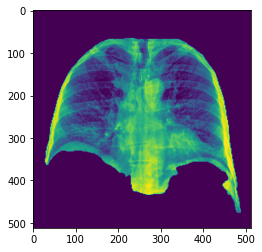

In [56]:
r1 = np.random.randint(0, len(traingen))
r2 = np.random.randint(0, traingen[r1][0].shape[0])
plt.imshow(traingen[r1][0][r2])

In [71]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras import layers
from tensorflow.keras import models
import tensorflow as tf


pix = 512
epoch = 200
batch = 8
fine_tune_at = 384
lr = 1e-4
opt = tf.keras.optimizers.Adam(learning_rate = lr)
loss = loss = 'binary_crossentropy'
met = ['BinaryAccuracy', 'Precision', 'AUC']


input_shape = (pix,pix,3)
conv_base = EfficientNetB3(weights="imagenet", include_top=False, input_shape=input_shape)

img_model = models.Sequential()
img_model.add(layers.Conv2D(3,3,padding="same", input_shape=(pix,pix,1), activation='elu', name = 'conv_inicial'))
img_model.add(conv_base)
img_model.add(layers.GlobalMaxPooling2D(name="general_max_pooling"))
img_model.add(layers.Dropout(0.2, name="dropout_out_1"))
img_model.add(layers.Dense(768, activation="elu"))
img_model.add(layers.Dense(256, activation="elu"))
img_model.add(layers.Dense(128, activation="elu"))
img_model.add(layers.Dropout(0.2, name="dropout_out_2"))
img_model.add(layers.Dense(64, activation="elu"))
img_model.add(layers.Dense(32, activation="elu"))
img_model.add(layers.Dropout(0.2, name="dropout_out_3"))
img_model.add(layers.Dense(16, activation="elu"))
img_model.add(layers.Dense(3, activation="sigmoid", name="fc_out"))


conv_base.trainable = True
for layer in conv_base.layers[:fine_tune_at]:
    layer.trainable = False

In [72]:
img_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_inicial (Conv2D)        (None, 512, 512, 3)       30        
_________________________________________________________________
efficientnetb3 (Functional)  (None, 16, 16, 1536)      10783535  
_________________________________________________________________
general_max_pooling (GlobalM (None, 1536)              0         
_________________________________________________________________
dropout_out_1 (Dropout)      (None, 1536)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 768)               1180416   
_________________________________________________________________
dense_25 (Dense)             (None, 256)               196864    
_________________________________________________________________
dense_26 (Dense)             (None, 128)              

In [73]:
img_model.compile(optimizer=opt, loss = loss , metrics = met)

history = img_model.fit(traingen, 
                    validation_data = testgen,
                    batch_size = batch,
                    #callbacks = callb,
                    epochs = epoch,
                    shuffle = True)

Epoch 1/200
63/63 [==============================] - 293s 4s/step - loss: 0.8381 - binary_accuracy: 0.5630 - precision: 0.3313 - auc: 0.5045 - val_loss: 0.5980 - val_binary_accuracy: 0.6400 - val_precision: 0.4600 - val_auc: 0.6575
Epoch 2/200
29/63 [============>.................] - ETA: 1:09 - loss: 0.6789 - binary_accuracy: 0.6207 - precision: 0.3740 - auc: 0.5376

KeyboardInterrupt: 